In [1]:
import pandas as pd
import os
import numpy as np
import hashlib

# matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
HOUSING_PATH = "../../ROOT_DATA/cali_housing/"

In [3]:
def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

In [4]:
# view sample housing data
housing_df = load_housing_data()
housing_df.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


In [20]:
housing_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


`ocean_proximity` is an object, while the rest are float64. We can inspect this seies with pandas pretty easily

In [30]:
housing_df["ocean_proximity"].describe()

count         20640
unique            5
top       <1H OCEAN
freq           9136
Name: ocean_proximity, dtype: object

In [22]:
housing_df["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [34]:
# what if I wanted to get the labels and values into their
# own array?
print(housing_df["ocean_proximity"].axes)
print(housing_df["ocean_proximity"].values)

[RangeIndex(start=0, stop=20640, step=1)]
['NEAR BAY' 'NEAR BAY' 'NEAR BAY' ... 'INLAND' 'INLAND' 'INLAND']


In [35]:
## (One-hot) encode these
one_hot = pd.get_dummies(housing_df["ocean_proximity"])
housing_df_num = housing_df.drop("ocean_proximity", axis=1)
housing_df_num = housing_df_num.join(one_hot)

In [36]:
print(housing_df_num.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 14 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
<1H OCEAN             20640 non-null uint8
INLAND                20640 non-null uint8
ISLAND                20640 non-null uint8
NEAR BAY              20640 non-null uint8
NEAR OCEAN            20640 non-null uint8
dtypes: float64(9), uint8(5)
memory usage: 1.5 MB
None


## Split into training and test

In [48]:
# split data into train|test by passed ratio (with seed)
def split_train_test(data, test_ratio, SEED=42):
    
    # shuffle (with seed)
    np.random.seed(SEED) # ensure consistency
    # TODO: (NOTE: if data is added, this seed will not keep the data
    # consistant a better method is needed). 
    # This could be achieved by using an identifier
    shuffled_indices = np.random.permutation(len(data))
    
    # set partition index(based on ratio) and split
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    
    return data.iloc[train_indices], data.iloc[test_indices]

In [52]:
# split 80% train, 20 test
train_df, test_df = split_train_test(data=housing_df_num, test_ratio=0.2)

# ensure it's been split properly
print("{:8d} training\n{:8d} test".format(len(train_df), len(test_df)))

   16512 training
    4128 test


In [53]:
# we'd like to be able to predict house prices based on the available
# data, so let's look for any linear correlations

# doc: https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.corr.html
corr_matrix = train_df.corr(method="pearson")

mhv_corr = corr_matrix["median_house_value"].sort_values(ascending=False)
print(mhv_corr)

median_house_value    1.000000
median_income         0.690647
<1H OCEAN             0.258544
NEAR BAY              0.162134
NEAR OCEAN            0.134263
total_rooms           0.133989
housing_median_age    0.103706
households            0.063714
total_bedrooms        0.047980
ISLAND                0.020983
population           -0.026032
longitude            -0.046349
latitude             -0.142983
INLAND               -0.482862
Name: median_house_value, dtype: float64


In [54]:
# In this case only median_income seems to have a high linear correlation
mhv_corr_top = mhv_corr.iloc[:2]
print(mhv_corr_top.index)

Index(['median_house_value', 'median_income'], dtype='object')


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb2635a6da0>,
      dtype=object)

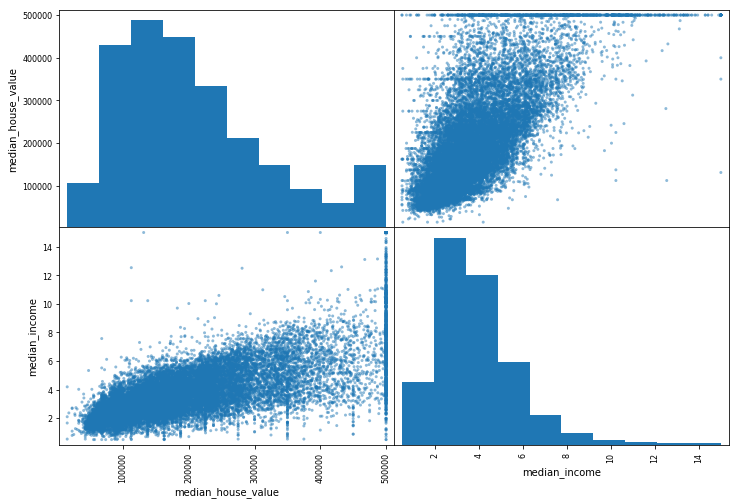

In [55]:
from pandas.plotting import scatter_matrix
scatter_matrix(housing_df_num[mhv_corr_top.index], figsize=(12,8))